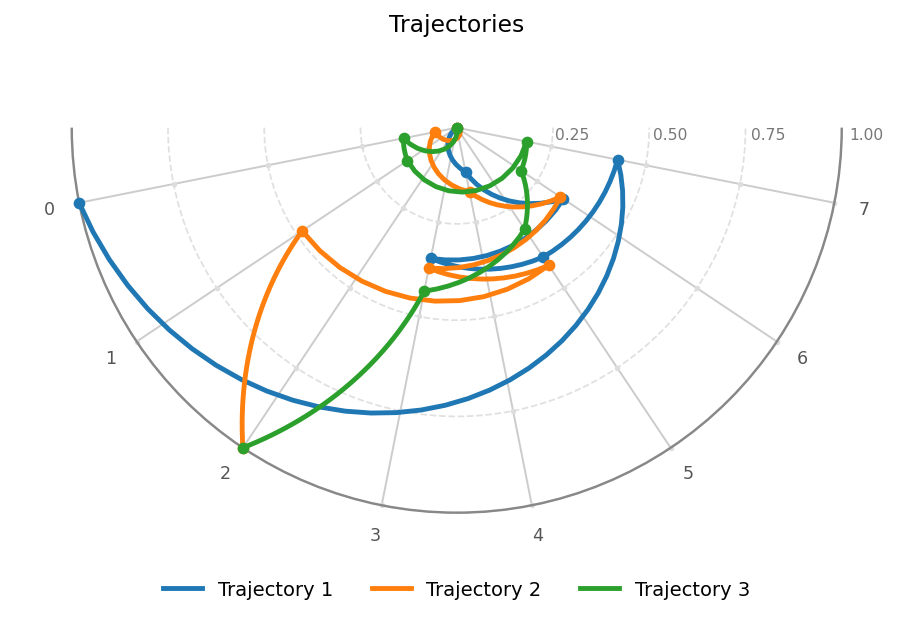

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Data
trajectories = [
    {
        "path": [1, 4, 6, 3, 5, 7, 0],
        "pseudotimes": ["0.000", "0.117", "0.333", "0.346", "0.404", "0.426", "1.000"],
    },
    {
        "path": [7, 0, 4, 6, 3, 5, 1, 2],
        "pseudotimes": ["0.000", "0.057", "0.170", "0.324", "0.372", "0.430", "0.483", "1.000"],
    },
    {
        "path": [4, 0, 1, 7, 6, 5, 3, 2],
        "pseudotimes": ["0.000", "0.141", "0.154", "0.185", "0.201", "0.317", "0.433", "1.000"],
    },
]

# Number of radial lines determined by max node id in the data (IDs 0..max)
all_ids = sorted({int(n) for traj in trajectories for n in traj["path"]})
num_lines = (max(all_ids) + 1) if all_ids else 1
R = 1.0
# Use mid-bin angles to avoid lines at exact horizontals (-pi and 0)
step = np.pi / max(num_lines, 1)
angles = np.linspace(-np.pi + step / 2.0, 0.0 - step / 2.0, num_lines)

# Global pseudotime normalization so every radial line shares the same scale
all_times = [float(t) for traj in trajectories for t in traj["pseudotimes"]]
pt_min = min(all_times) if all_times else 0.0
pt_max = max(all_times) if all_times else 1.0

def normalize_time(t: float) -> float:
    if pt_max == pt_min:
        return 0.0
    return (t - pt_min) / (pt_max - pt_min)

fig, ax = plt.subplots(figsize=(9, 5), dpi=140)

# Semicircle boundary (outermost)
arc = Arc((0, 0), width=2 * R, height=2 * R, angle=0, theta1=180, theta2=360, color="#888888", lw=1.25)
ax.add_patch(arc)

# Concentric semicircles to indicate time scale (normalized radii)
scale_fracs = [0.25, 0.5, 0.75, 1.0]
for frac in scale_fracs:
    if frac <= 0.0 or frac > 1.0:
        continue
    tick_arc = Arc((0, 0), width=2 * R * frac, height=2 * R * frac, angle=0, theta1=180, theta2=360,
                   color="#E0E0E0", lw=0.9, linestyle="--", zorder=0)
    ax.add_patch(tick_arc)
    # Label approximate time at the rightmost point of each arc
    label_time = pt_min + frac * (pt_max - pt_min)
    ax.text(frac * R * 1.02, -0.00 * R, f"{label_time:.2f}", ha="left", va="top", fontsize=8, color="#777777")

# Radial lines and labels
for i, theta in enumerate(angles):
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    ax.plot([0, x], [0, y], color="#CCCCCC", lw=1.0, zorder=0)
    ax.text(1.08 * np.cos(theta), 1.08 * np.sin(theta), str(i), ha="center", va="center", fontsize=9, color="#555555")

# Uniform tick marks to show shared time scale (0..1 after normalization)
for theta in angles:
    for frac in np.linspace(0.0, 1.0, 5):  # 0, .25, .5, .75, 1
        rt = frac * R
        ax.plot(rt * np.cos(theta), rt * np.sin(theta), marker='o', markersize=1.8, color="#DDDDDD", zorder=0)

# Plot trajectories
cmap = plt.get_cmap("tab10")
for idx, traj in enumerate(trajectories):
    color = cmap(idx % 10)
    path = traj["path"]
    times = [float(t) for t in traj["pseudotimes"]]

    # Compute node positions (markers)
    node_thetas, node_rs, nodes_x, nodes_y = [], [], [], []
    for node_id, t in zip(path, times):
        node_id = int(node_id)
        if node_id < 0 or node_id >= num_lines:
            continue
        theta = angles[node_id]
        r = np.clip(normalize_time(t), 0.0, 1.0) * R
        node_thetas.append(theta)
        node_rs.append(r)
        nodes_x.append(r * np.cos(theta))
        nodes_y.append(r * np.sin(theta))

    # Build a time-based polyline by interpolating between consecutive nodes in time
    line_x, line_y = [], []
    for i in range(len(node_thetas) - 1):
        theta0, theta1 = node_thetas[i], node_thetas[i + 1]
        t0, t1 = times[i], times[i + 1]
        # Sample more points for larger time spans
        n_samples = max(12, int(60 * abs(t1 - t0) / max(pt_max - pt_min, 1e-9)))
        ts_arr = np.linspace(t0, t1, n_samples)
        thetas_arr = np.linspace(theta0, theta1, n_samples)
        if pt_max == pt_min:
            norms = np.zeros_like(ts_arr)
        else:
            norms = (ts_arr - pt_min) / (pt_max - pt_min)
        rs_arr = np.clip(norms, 0.0, 1.0) * R
        line_x.extend((rs_arr * np.cos(thetas_arr)).tolist())
        line_y.extend((rs_arr * np.sin(thetas_arr)).tolist())

    # Draw line and node markers
    ax.plot(line_x, line_y, color=color, lw=2.5, label=f"Trajectory {idx + 1}")
    ax.plot(nodes_x, nodes_y, color=color, lw=0, marker="o", markersize=5)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-R * 1.15, R * 1.15)
ax.set_ylim(-R * 1.2, R * 0.2)
ax.axis("off")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=len(trajectories), frameon=False)
ax.set_title(
    "Trajectories",
    pad=10,
)
plt.show()


In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import sparse
import anndata
import warnings
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import tempfile
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

cdata = sc.read_h5ad("../Example_Data/H1-TXK6Z4X-A1_2um/skin_TXK6Z4X_A1_2um_b2c_qc.h5ad")
cdata

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/siyuanzhao/Documents/GitHub/Biovis2025/Python"
  warnings.warn(
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T//RtmpuEr0DU", R: "/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T//RtmpRhIDSc"
  warnings.warn(


AnnData object with n_obs × n_vars = 78865 × 17079
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_labels', 'conf_score', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_cropped_150_buffer'
    obsp: 'connectivities', 'distances'

In [ ]:
import numpy as np

gene_sums = np.array(cdata.X.sum(axis=0)).flatten()

top_n = 10
top_indices = np.argsort(gene_sums)[::-1][:top_n]

for i in top_indices:
    print(f"{cdata.var_names[i]}: {gene_sums[i]}")


S100A9: 975643.8441456604
S100A8: 970935.470105043
KRT5: 553561.993901278
COL1A1: 482470.4116712582
COL3A1: 435897.8371830378
KRT16: 359153.7814431832
COL1A2: 260600.88924825928
KRT6B: 253413.75206945388
KRT6A: 230802.08011970128
TMSB4X: 187211.16349432548
